# Validation: Heldout Data Example

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* holds-out the final few days of the data, and see's if they can be predicted. 

The way I propose doing this is holding out the confirmed observations for the final three days of the day for every country, and then plotting it for validation. This effectively changes the output model. 

In [345]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [346]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor


%matplotlib inline

INFO:epimodel.regions:Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   .. mean  .. max
 0 Gatherings limited to                      0.000 .. 0.177 .. 0.982
 1 Business suspended                         0.000 .. 0.273 .. 1.000
 2 Schools and universities closed            0.000 .. 0.361 .. 1.000
 3 General curfew                             0.000 .. 0.167 .. 1.000
 4 Healthcare specialisation                  0.000 .. 0.020 .. 0.429
 5 Phone line                                 0.000 .. 0.032 .. 1.000
 6 Asymptomatic contact isolation             0.000 .. 0.053 .. 1.000


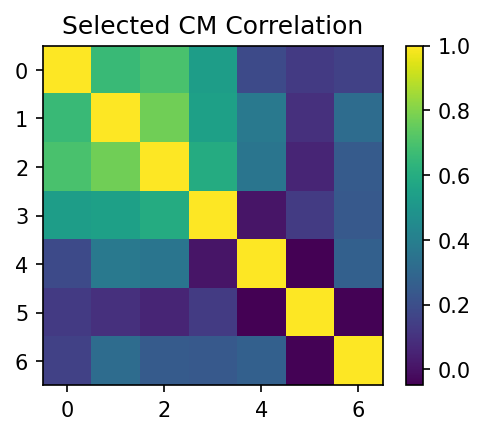

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}


In [347]:
regions = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "FI", "NO", "SE", "SI", "SK"]
features = ['Gatherings limited to', 'Business suspended', 'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Phone line', 'Asymptomatic contact isolation']

dp = DataPreprocessor()
data = dp.preprocess_data("../../data", regions, features)

In [389]:
with cm_effect.models.CMModelFlexibleV3(data) as model:
    model.build_cm_reduction_prior()
    model.build_region_growth_prior()
    model.build_region_reliability_prior(pm.Normal, {"mu": 1, "sigma": 0.05})
    model.build_rates()
    model.build_output_model()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


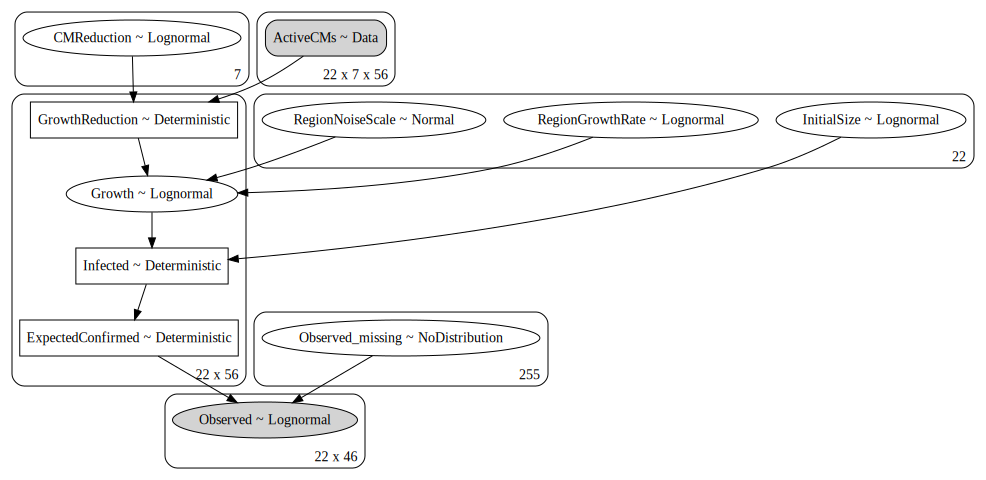

In [390]:
pm.model_to_graphviz(model).render("modelV3")
pm.model_to_graphviz(model)

In [391]:
model.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__            -1.58
RegionGrowthRate_log__       -0.06
RegionNoiseScale             45.69
Growth_log__               2059.08
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -22636.62
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
Sampling 2 chains, 16 divergences: 100%|██████████| 5000/5000 [13:35<00:00,  6.13draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9062130453264277, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9075100841574212, but should be close to

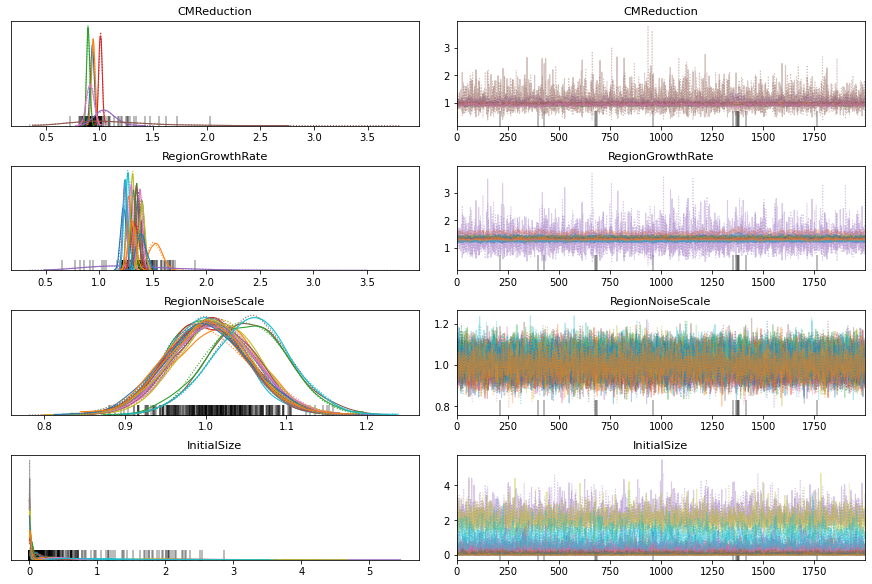

In [392]:
_ = model.plot_traces()

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


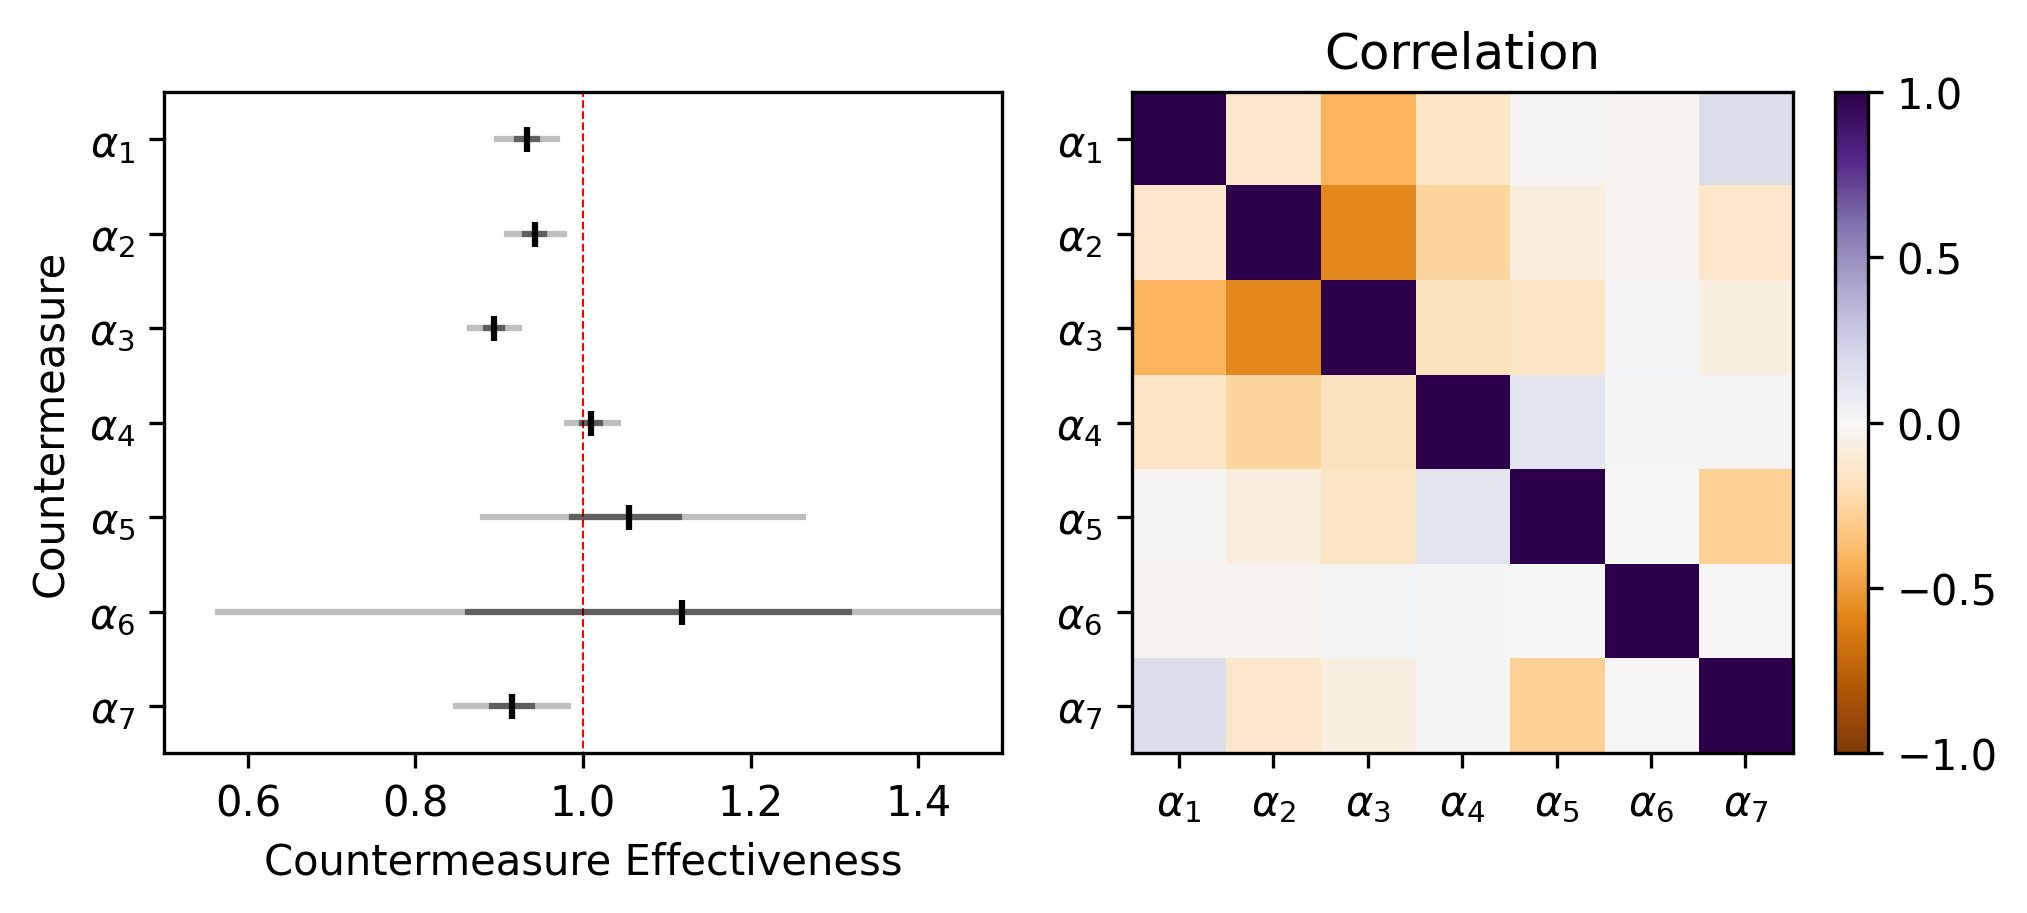

In [394]:
model.plot_effect()

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


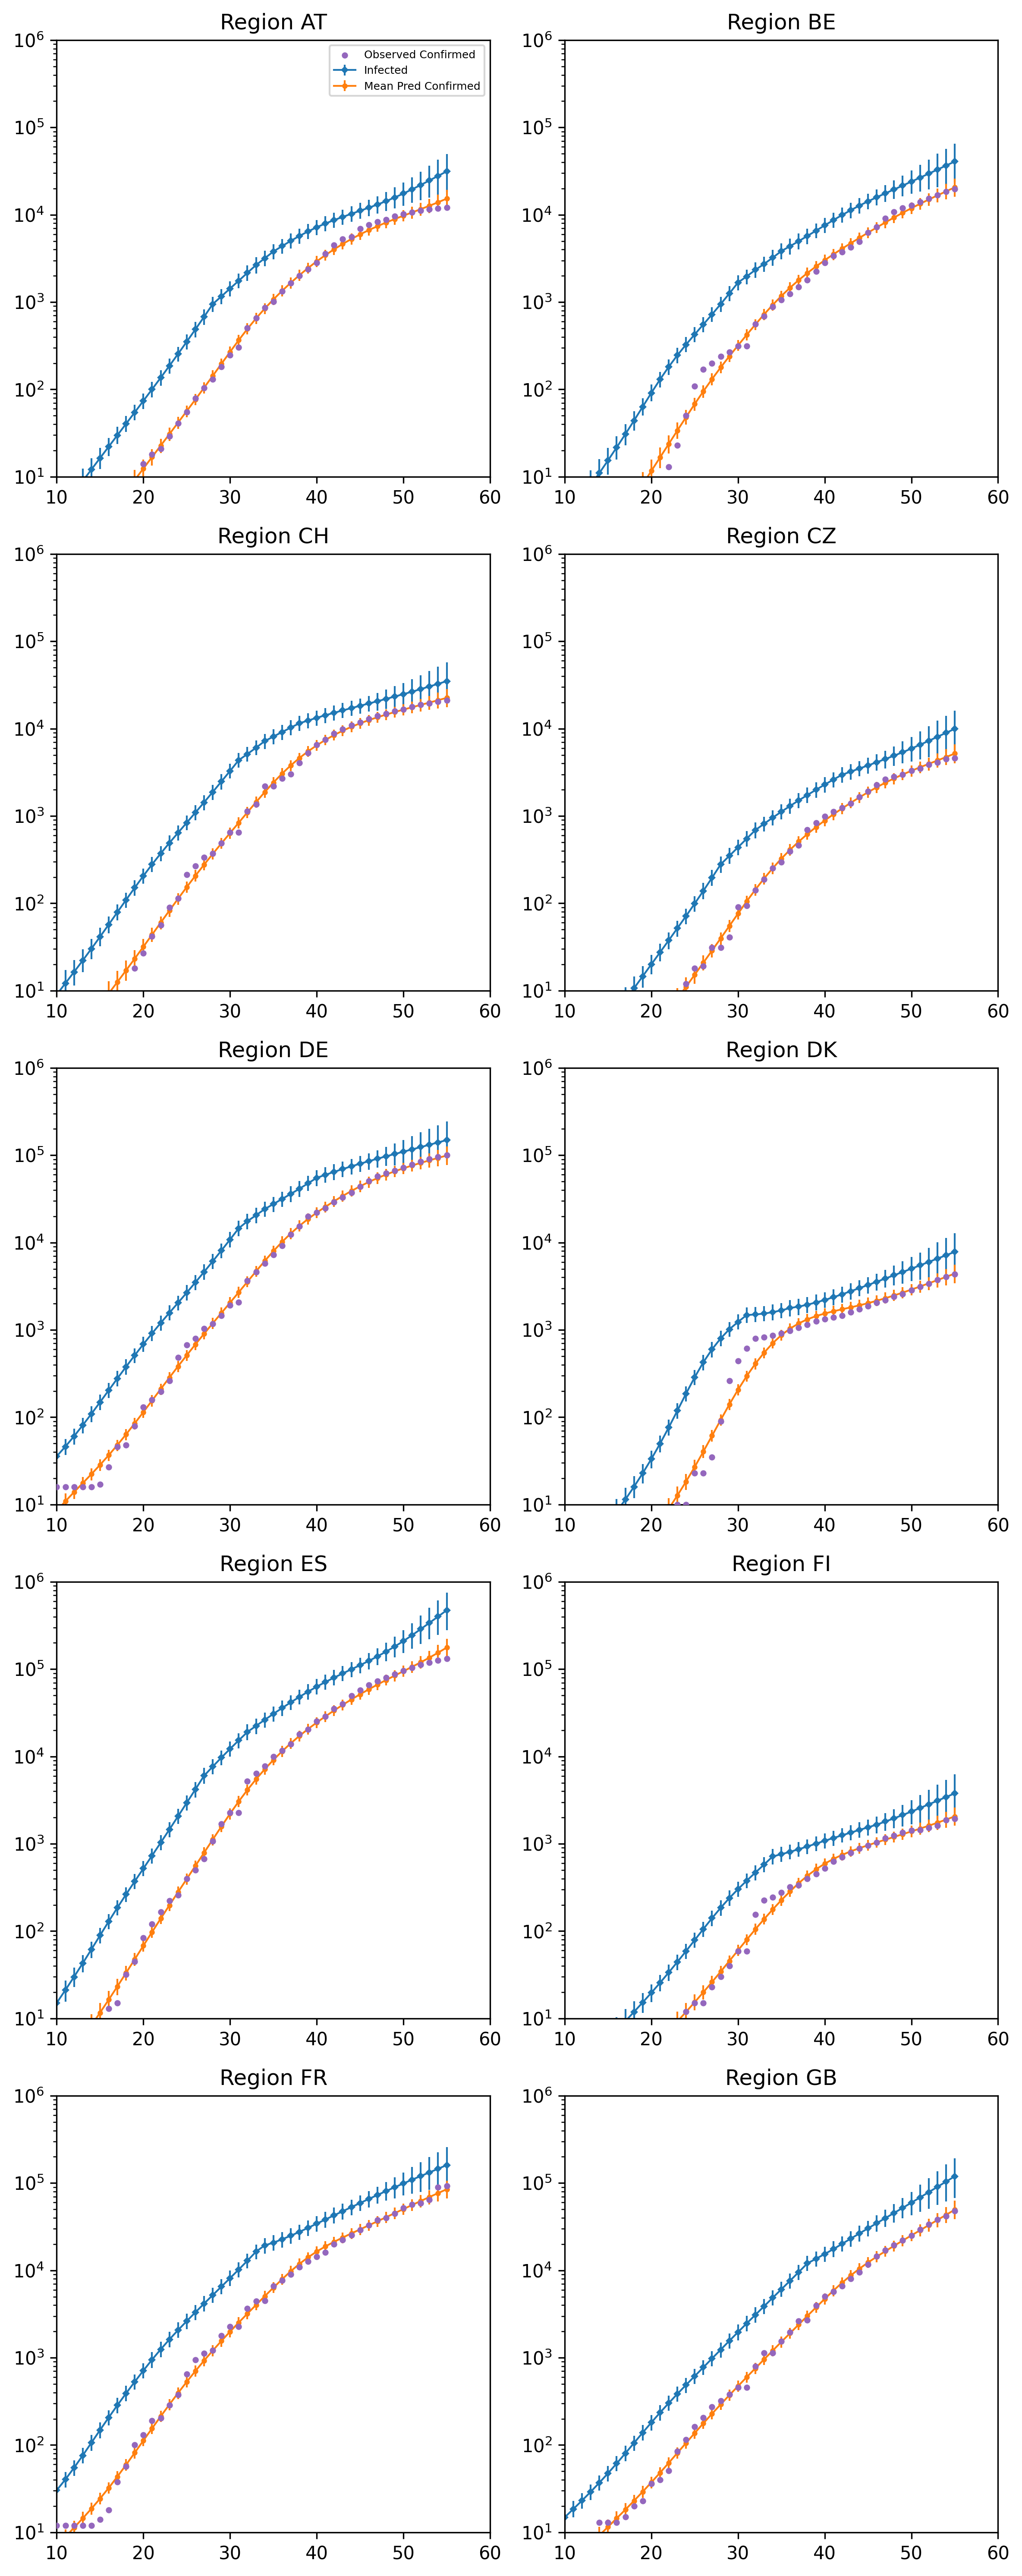

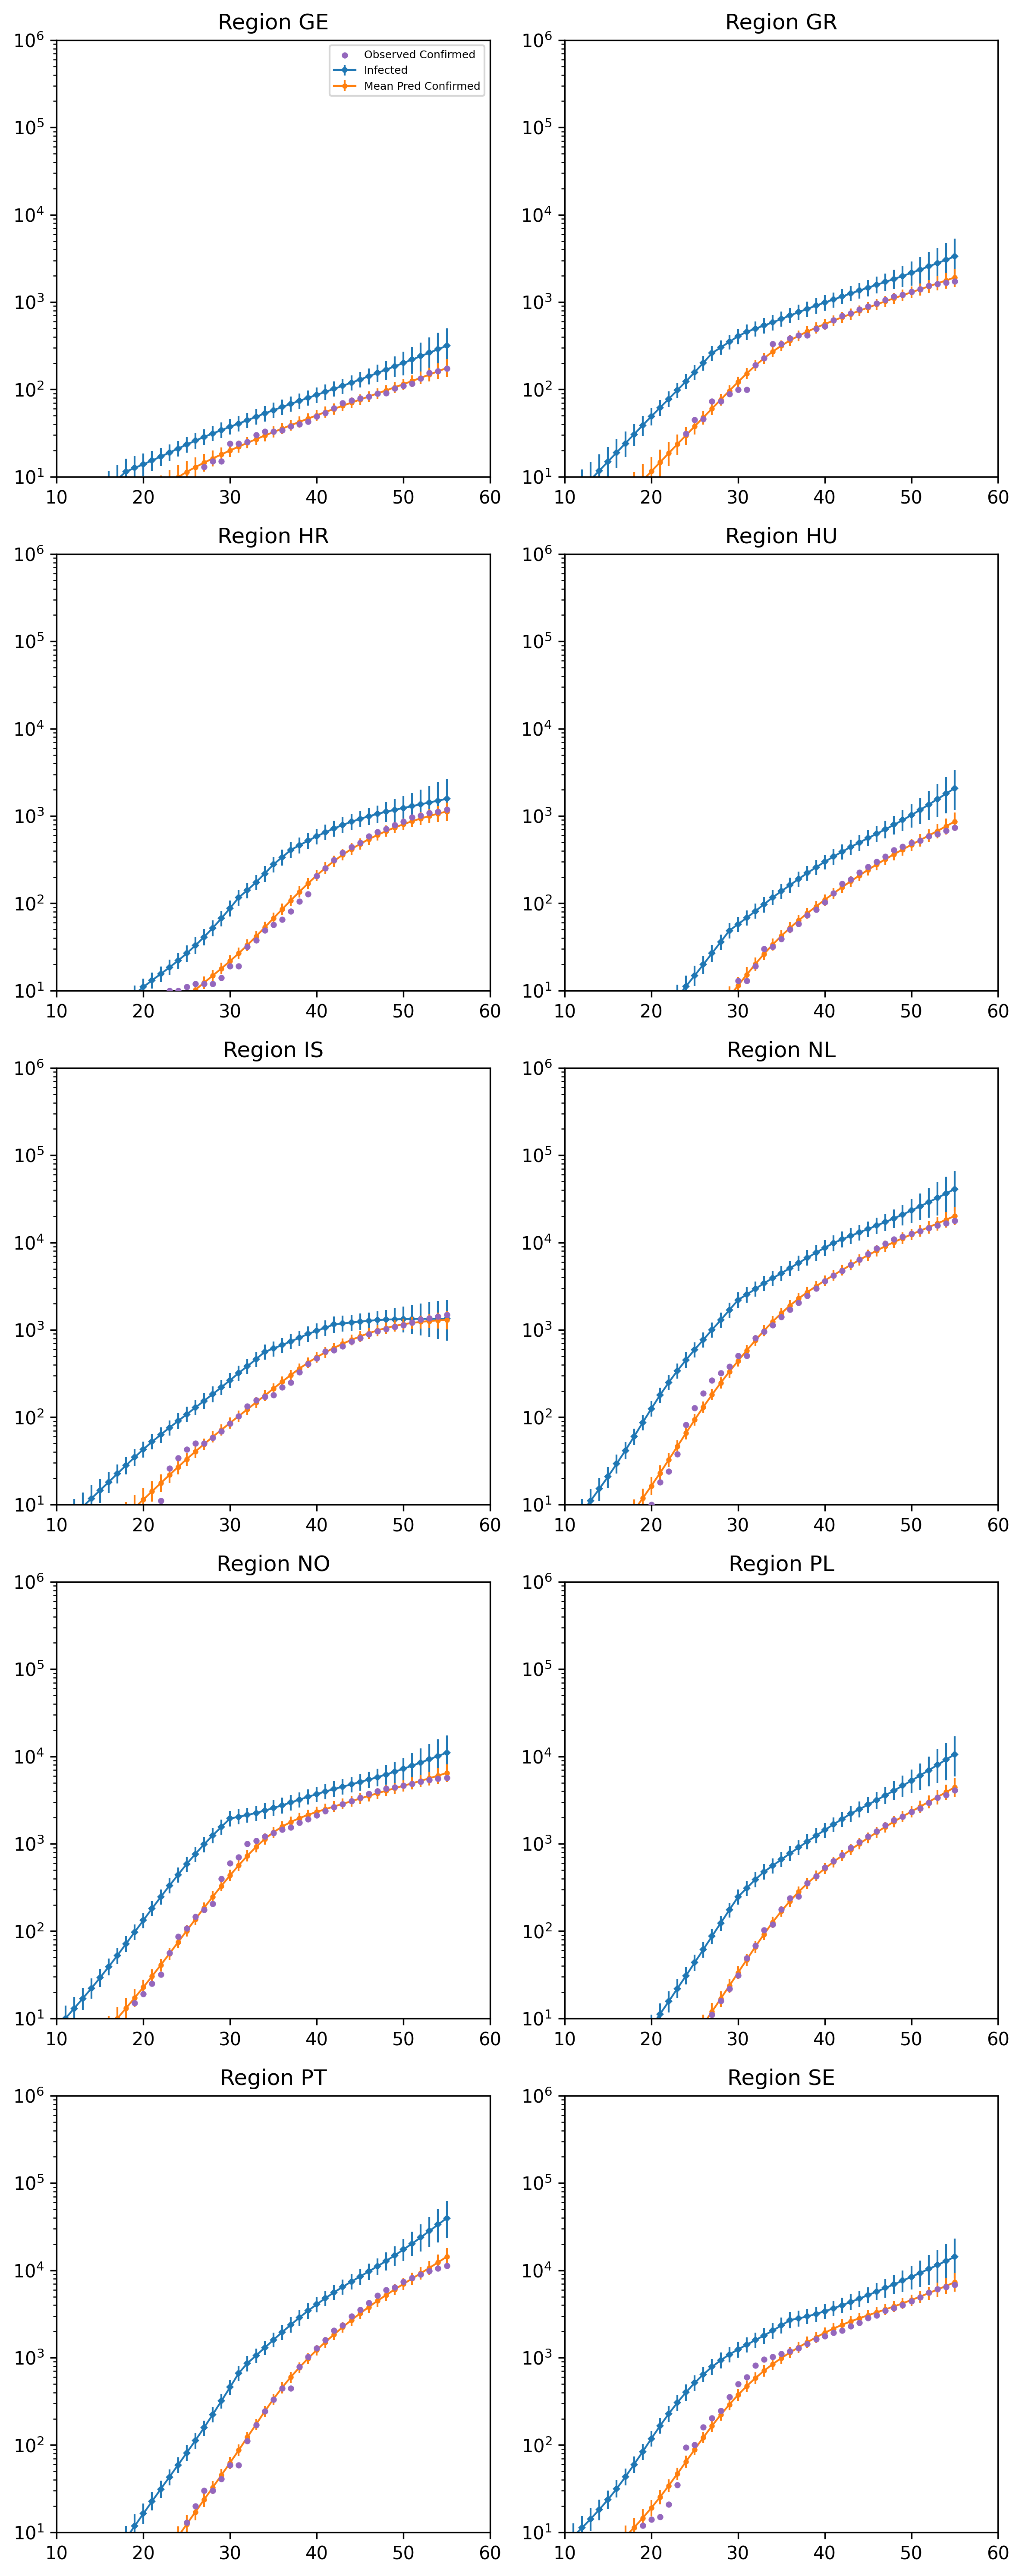

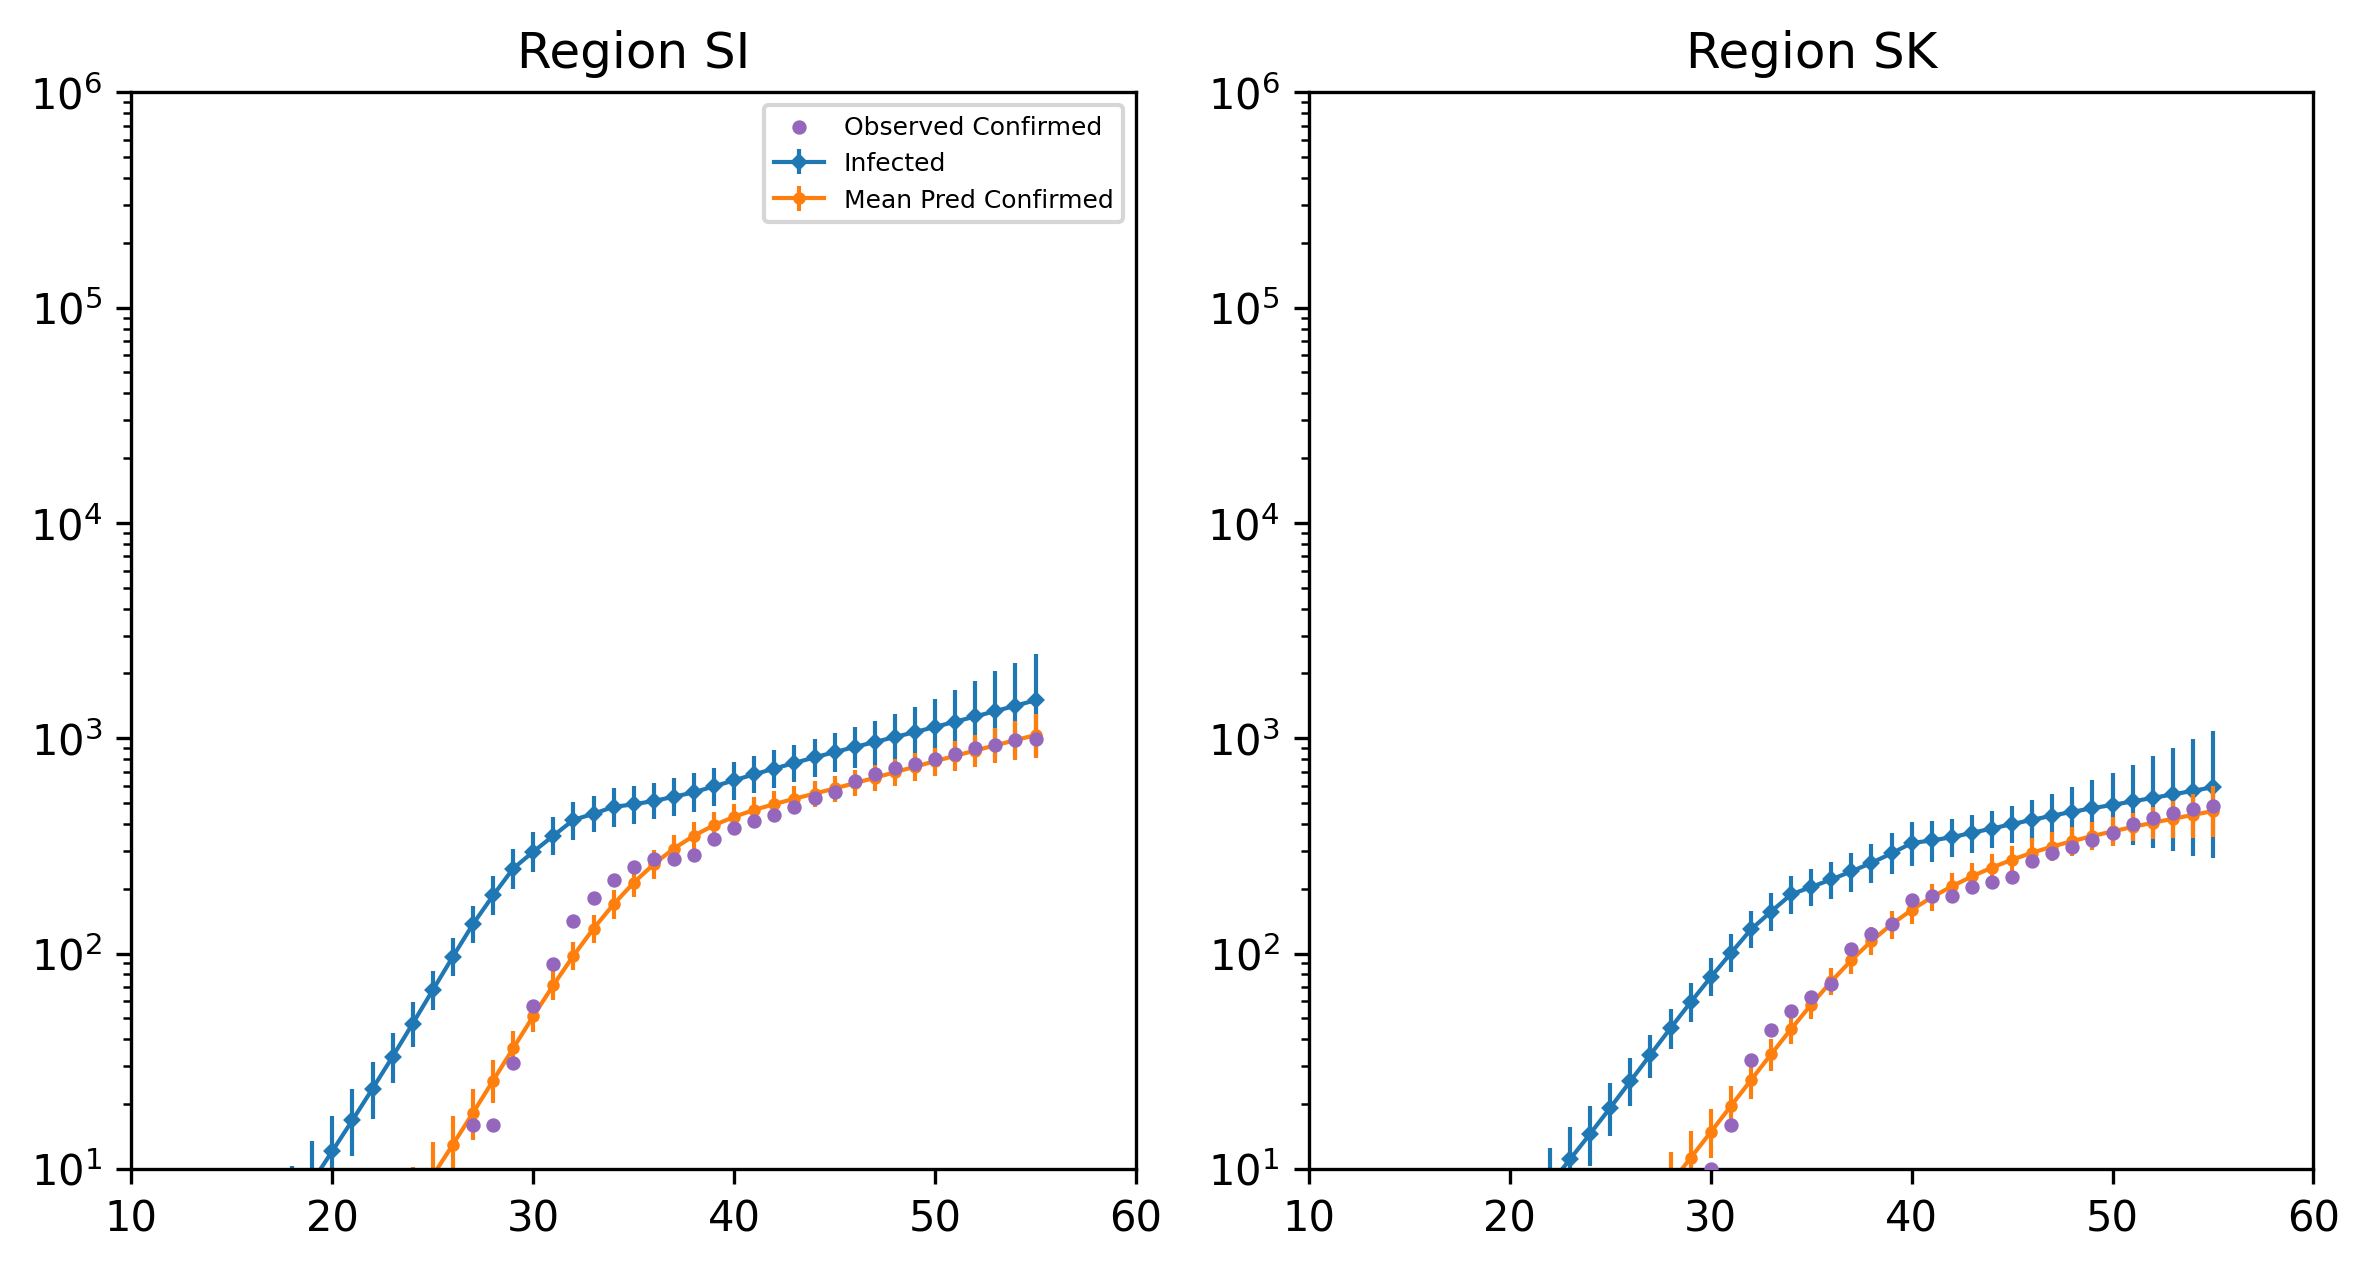

In [404]:
model.plot_region_predictions()

# Inspect Spain

Let's hold spain out. 

['AT', 'BE', 'CH', 'CZ', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'IS', 'NL', 'NO', 'PL', 'PT', 'SE', 'SI', 'SK']


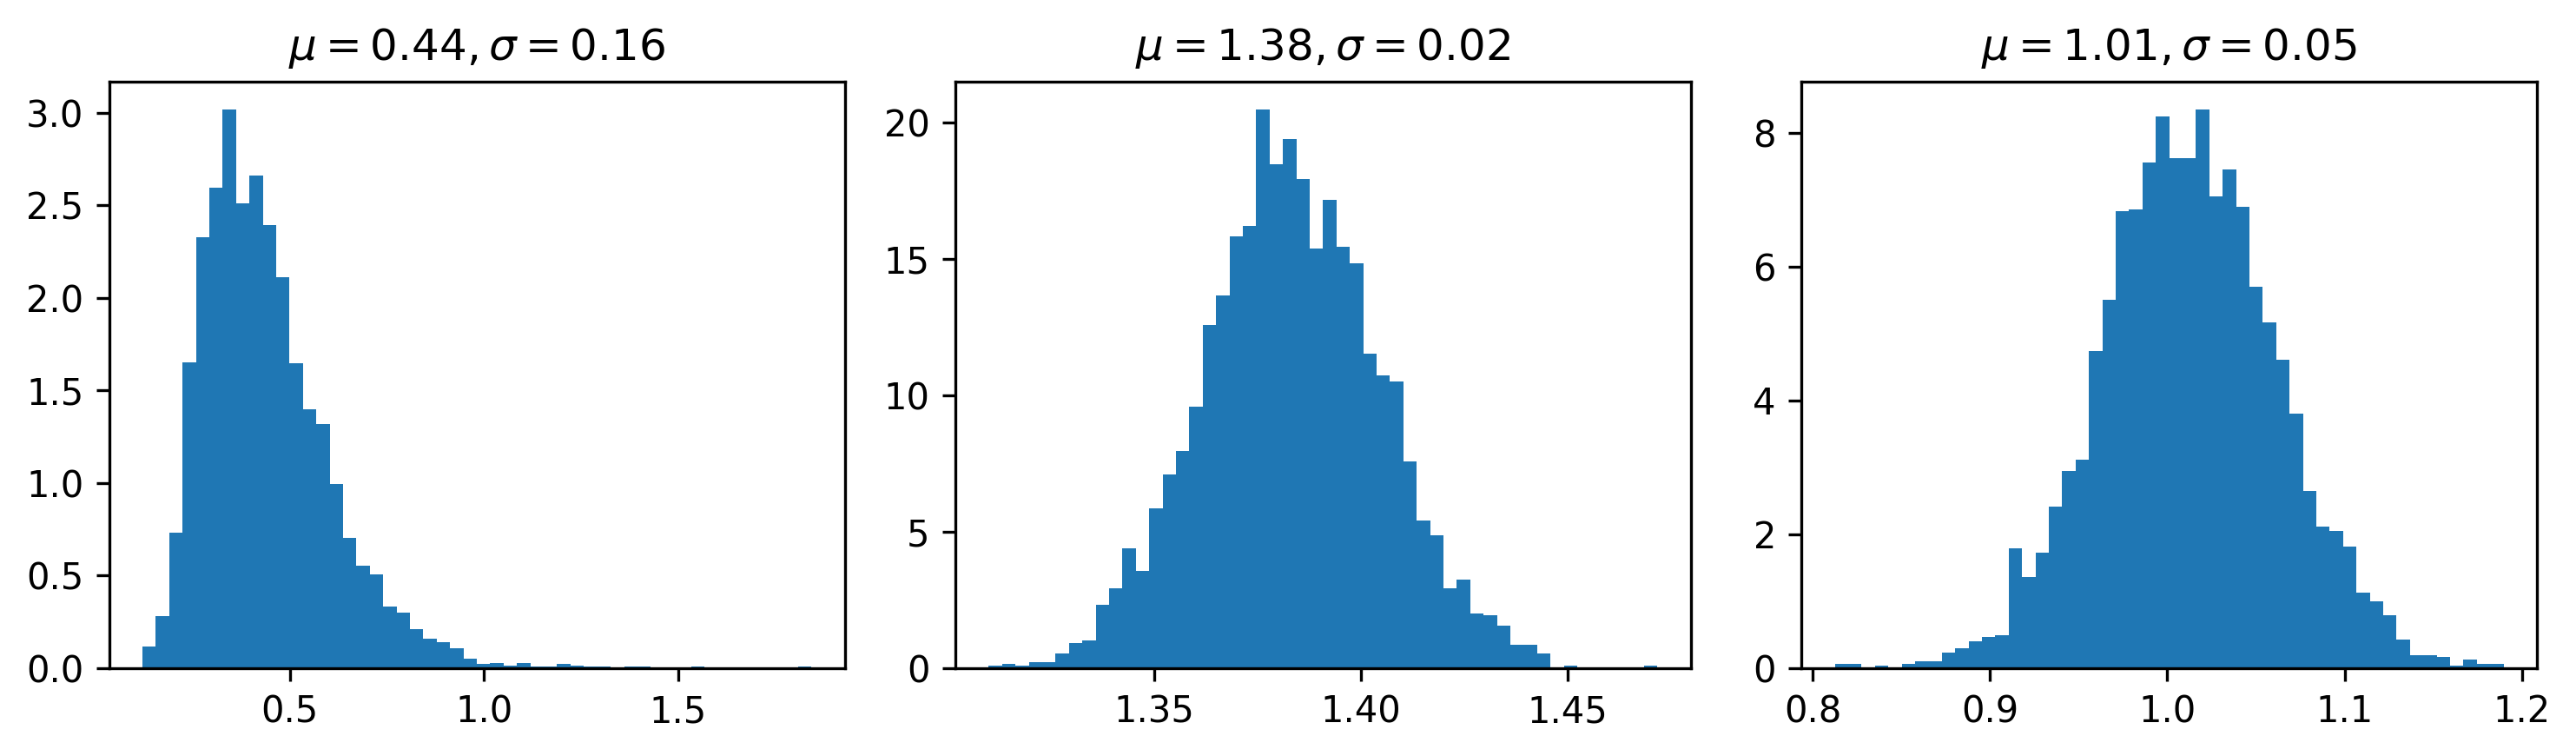

In [405]:
fig = plt.figure(figsize=(10, 3), dpi=300)
print(model.d.Rs)
plt.subplot(1, 3, 1)
plt.hist(model.trace["InitialSize"][:, 6], bins=50,  density=True)
plt.title(f"$\\mu = {np.mean(model.trace['InitialSize'][:, 6]):.2f}, \\sigma = {np.std(model.trace['InitialSize'][:, 6]):.2f}$") 
plt.subplot(1, 3, 2)
plt.hist(model.trace["RegionGrowthRate"][:, 6], bins=50,  density=True)
plt.title(f"$\\mu = {np.mean(model.trace['RegionGrowthRate'][:, 6]):.2f}, \\sigma = {np.std(model.trace['RegionGrowthRate'][:, 6]):.2f}$")
plt.subplot(1, 3, 3)
plt.hist(model.trace["RegionNoiseScale"][:, 6], bins=50,  density=True)
plt.title(f"$\\mu = {np.mean(model.trace['RegionNoiseScale'][:, 6]):.2f}, \\sigma = {np.std(model.trace['RegionNoiseScale'][:, 6]):.2f}$") 
plt.tight_layout()

Worth noting that these distributions don't look particularly Gaussian for when we want to provide initial estimates. I'll use a normal distribution though. 

In [408]:
with cm_effect.models.CMModelFlexibleV3(data, heldout_regions=["ES"]) as model2:
    model2.build_cm_reduction_prior()
    model2.build_region_growth_prior()
    model2.build_region_reliability_prior(pm.Normal, {"mu": 1, "sigma": 0.05})
    model2.build_heldout_region_priors(pm.Normal, {"mu": 0.44, "sigma": 0.16}, pm.Normal, {"mu": 1.38, "sigma": 0.02}, pm.Normal, {"mu": 1.01, "sigma": 0.05})
    model2.build_rates()
    model2.build_output_model()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


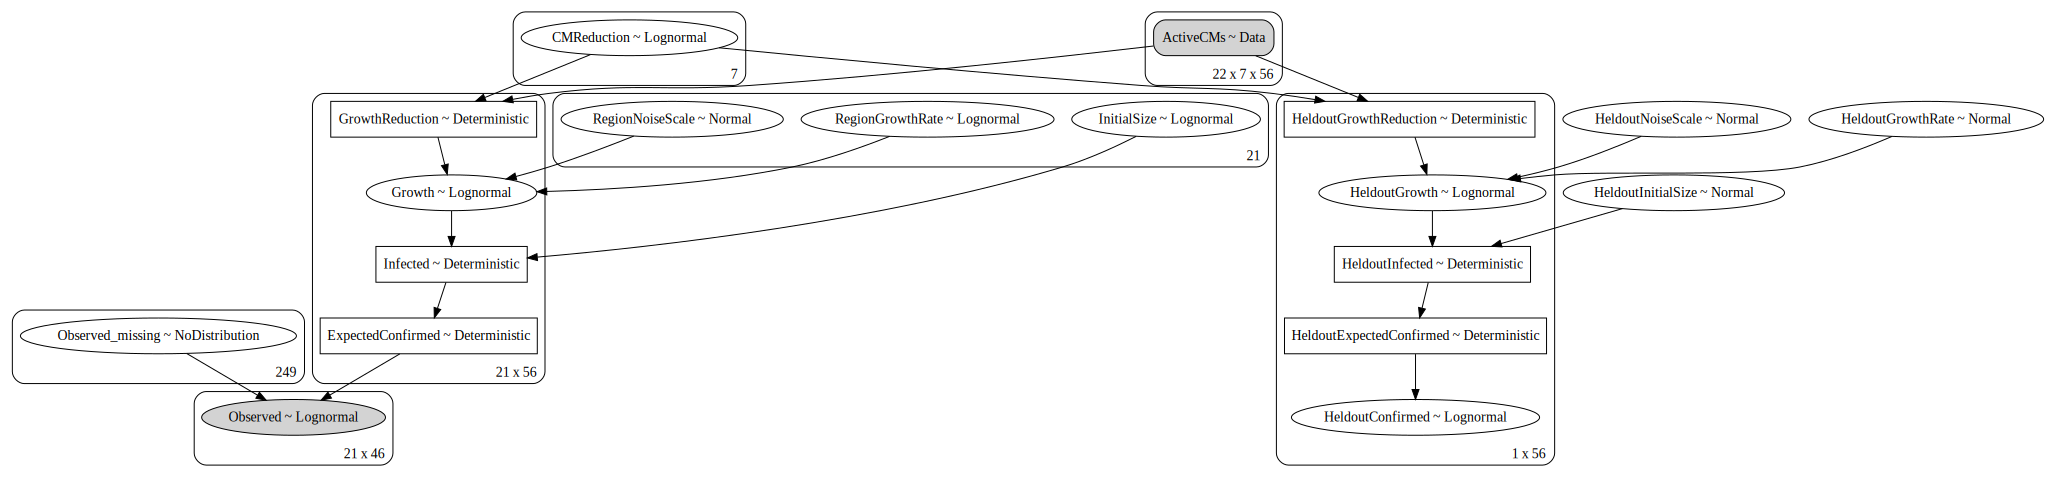

In [409]:
pm.model_to_graphviz(model2).render("modelV3-ESHeldout")
pm.model_to_graphviz(model2)

In [410]:
model2.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__            -1.58
RegionGrowthRate_log__       -0.06
RegionNoiseScale             43.61
HeldoutInitialSize            0.91
HeldoutGrowthRate             2.99
HeldoutNoiseScale             2.08
Growth_log__               1965.48
HeldoutGrowth_log__          93.04
InitialSize_log__           -67.65
Observed_missing              0.00
HeldoutConfirmed_log__       26.17
Observed                 -19262.23
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [HeldoutConfirmed, Observed_missing, InitialSize, HeldoutGrowth, Growth, HeldoutNoiseScale, HeldoutGrowthRate, HeldoutInitialSize, RegionNoiseScale, RegionGrowthRate, CMReduction]
INFO:pymc3:NUTS: [HeldoutConfirmed, Observed_missing, InitialSize, HeldoutGrowth, Growth, HeldoutNoiseScale, HeldoutGrowthRate, HeldoutInitialSize, RegionNoiseScale, RegionGrowthRate, CMReduction]
Sampling 2 chains, 12 divergences: 100%|██████████| 5000/5000 [17:46<00:00,  4.69draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9290389320075384, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


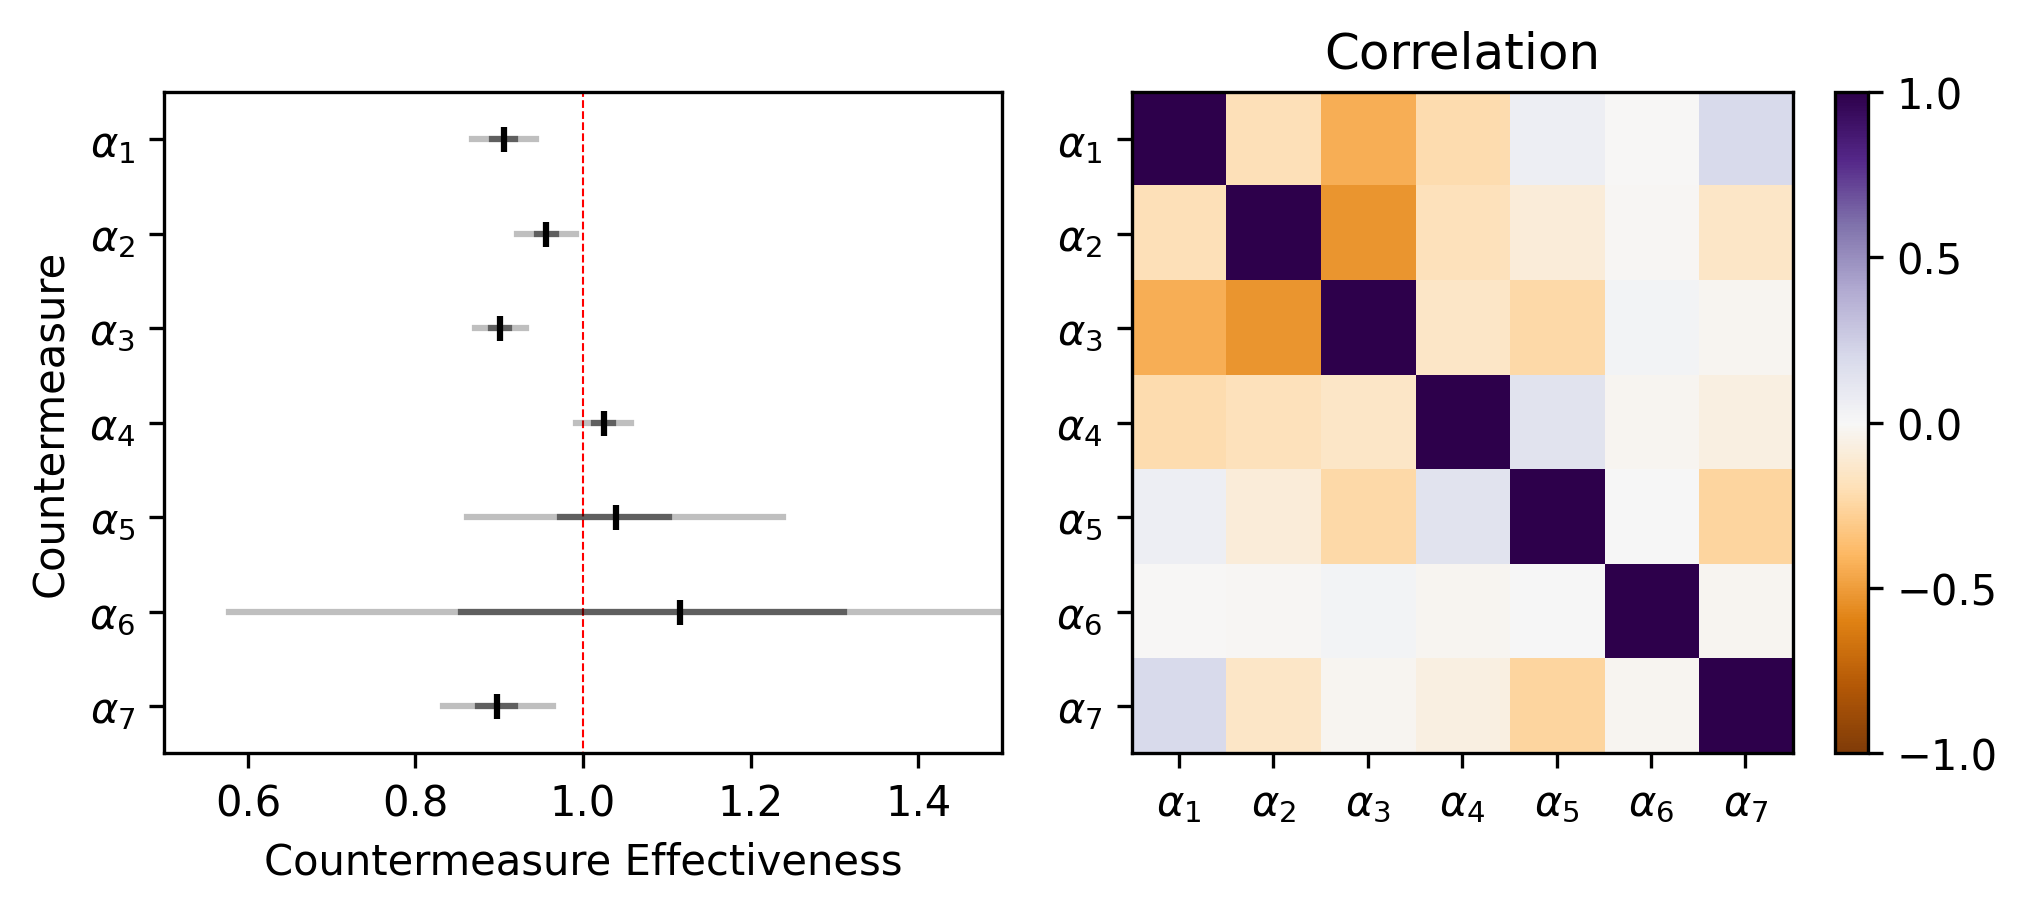

In [411]:
model2.plot_effect()

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


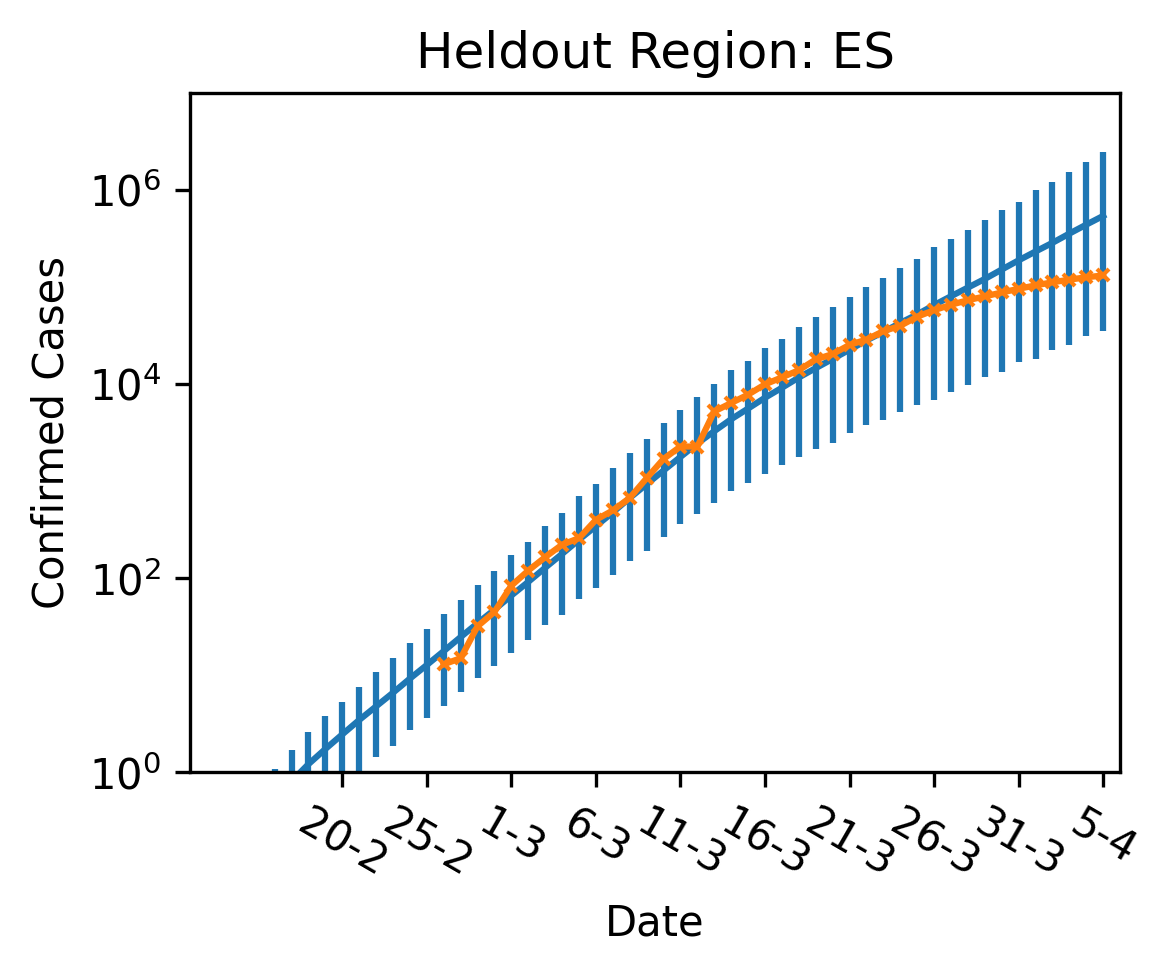

In [412]:
model2.heldout_regions_validation_plot()

# Let's holdout the final 3 days. 

In [423]:
with cm_effect.models.CMModelFlexibleV3(data, heldout_days=[53, 54, 55]) as model3:
    model3.build_cm_reduction_prior()
    model3.build_region_growth_prior()
    model3.build_region_reliability_prior(pm.Normal, {"mu": 1, "sigma": 0.05})
    model3.build_rates()
    model3.build_output_model()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


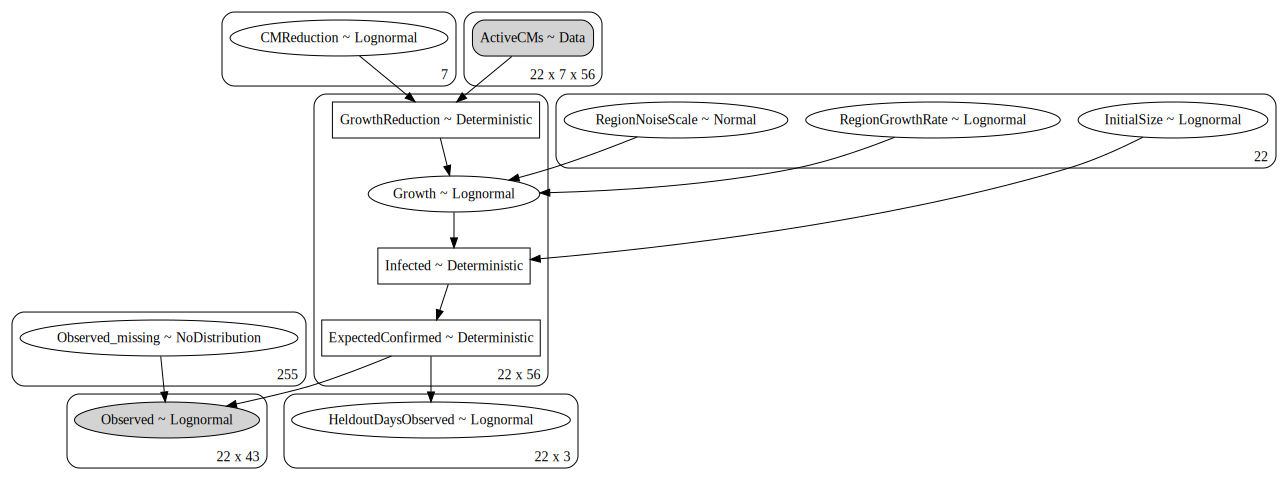

In [424]:
pm.model_to_graphviz(model3).render("modelV3-DaysHeldout")
pm.model_to_graphviz(model3)

In [425]:
model3.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__               -1.58
RegionGrowthRate_log__          -0.06
RegionNoiseScale                45.69
Growth_log__                  2059.08
InitialSize_log__              -70.87
Observed_missing                 0.00
HeldoutDaysObserved_log__       30.85
Observed                    -20421.77
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [HeldoutDaysObserved, Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
INFO:pymc3:NUTS: [HeldoutDaysObserved, Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [15:25<00:00,  5.40draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9093910554921879, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.89220

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


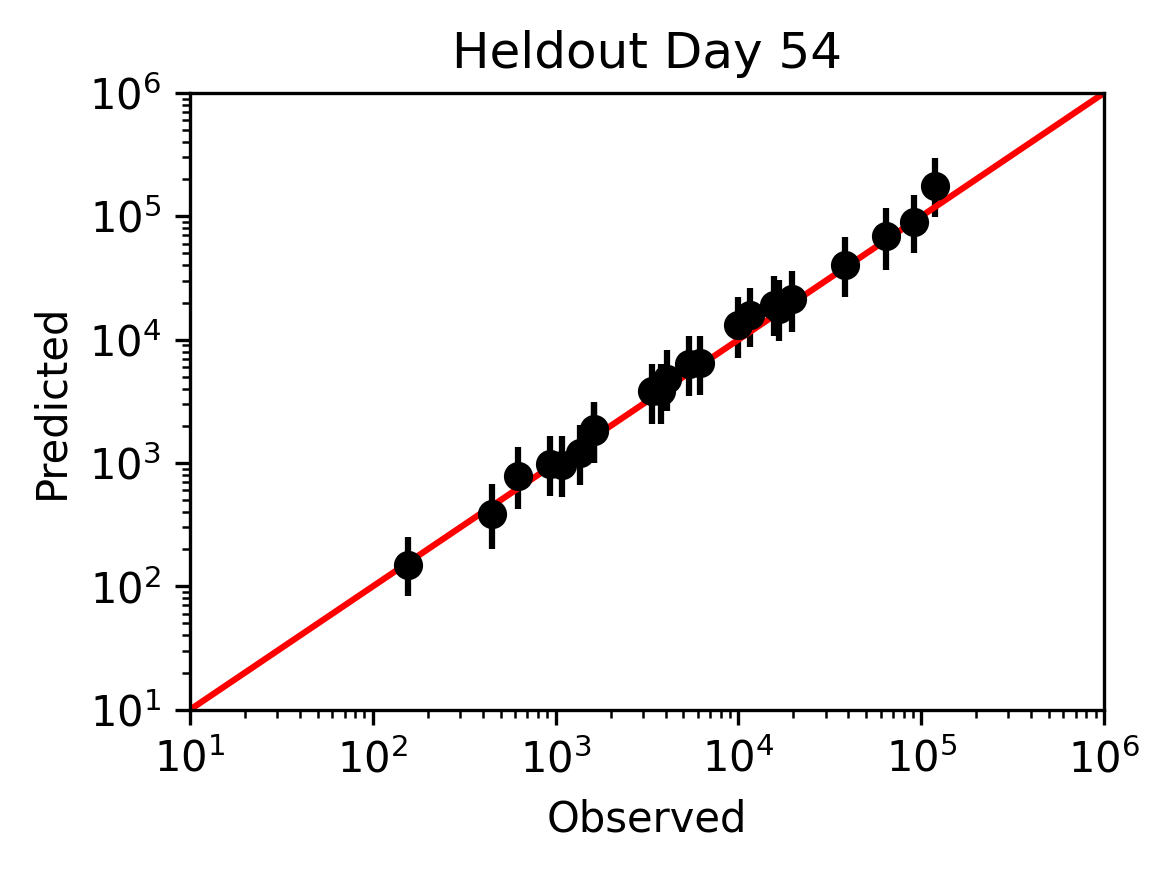

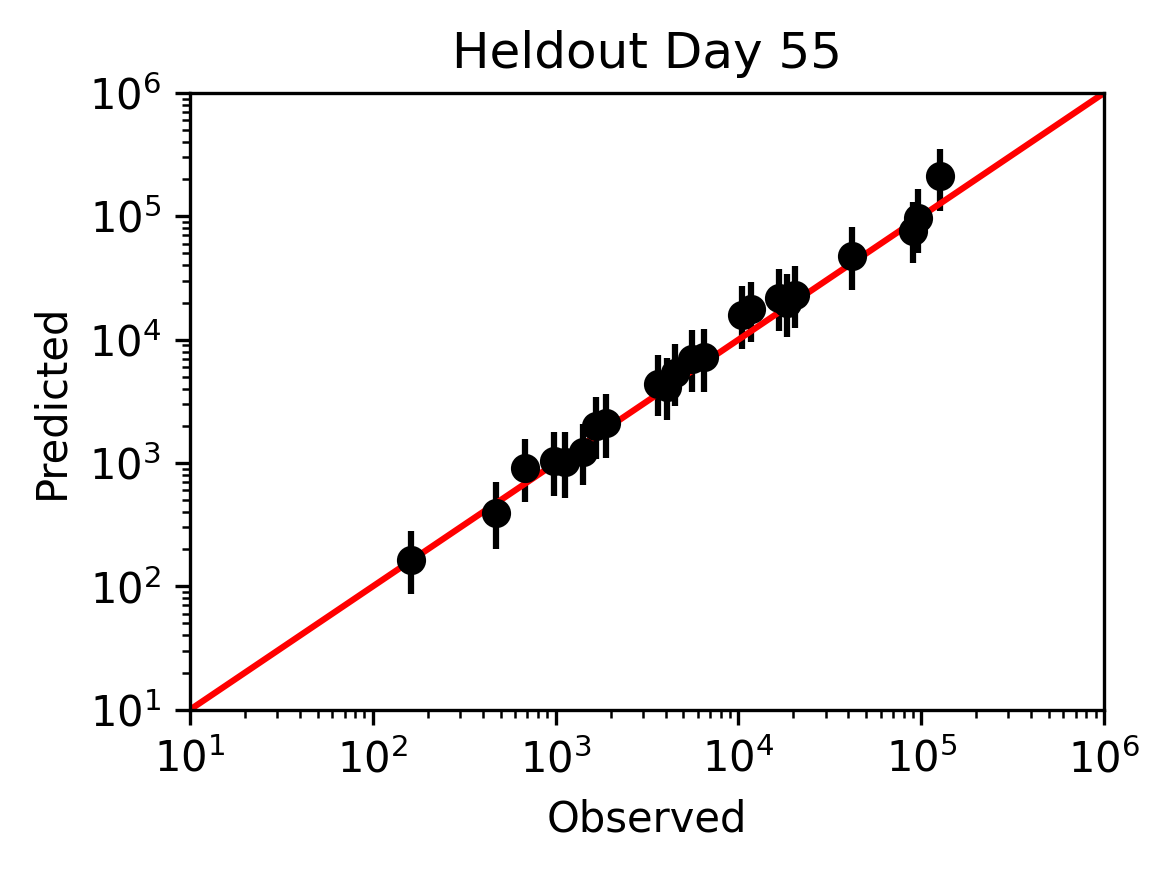

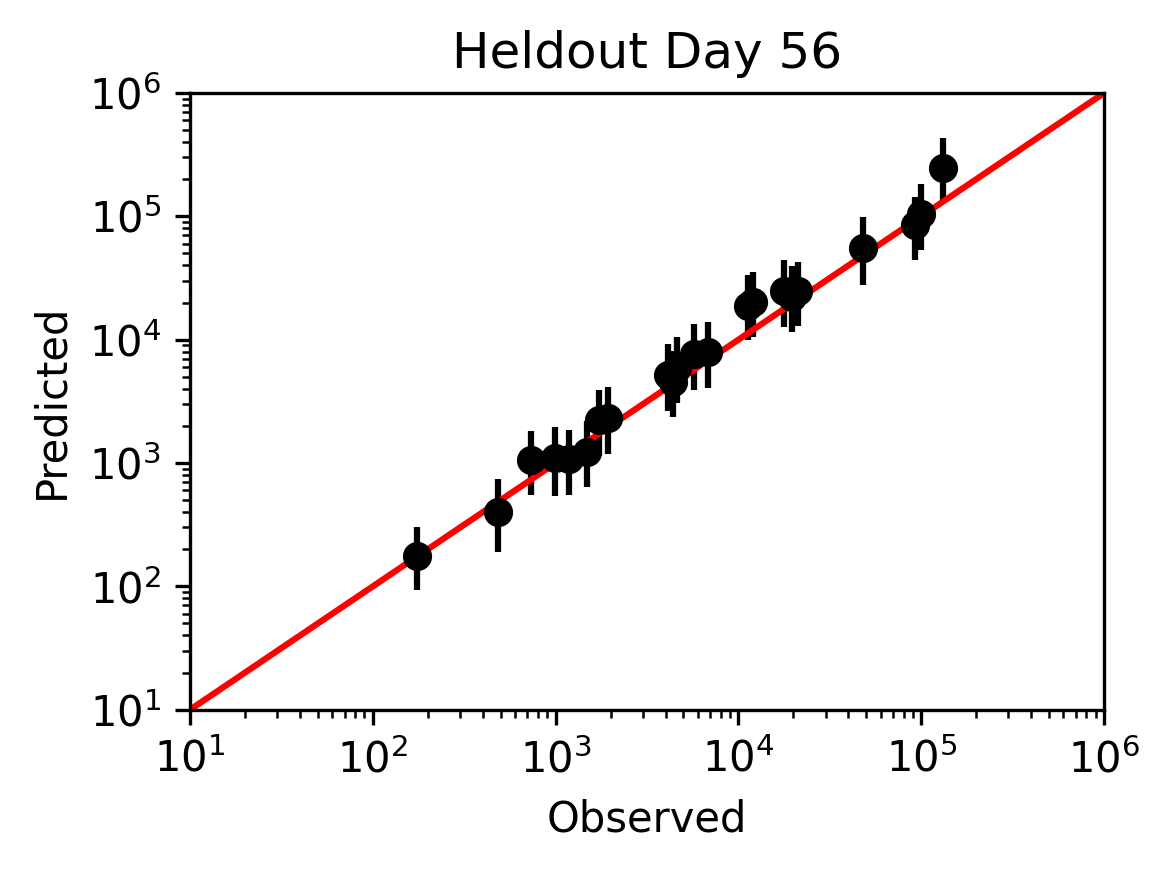

In [426]:
model3.heldout_days_validation_plot()

Compared to the above changes, lets make the following changes:

* Switch the prior to the ICL prior used. 
* Refine the country list
* switch to binary interventions
* use active rather than confirmed cases
* transform into log space

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   ... mean  ... max   ... unique
 1 Masks over 60                              0.000 ... 0.016 ... 1.000 ... [0. 1.]
 2 Asymptomatic contact isolation             0.000 ... 0.120 ... 1.000 ... [0. 1.]
 3 Gatherings limited to 10                   0.000 ... 0.153 ... 1.000 ... [0. 1.]
 4 Gatherings limited to 100                  0.000 ... 0.248 ... 1.000 ... [0. 1.]
 5 Gatherings limited to 1000                 0.000 ... 0.285 ... 1.000 ... [0. 1.]
 6 Business suspended - some                  0.000 ... 0.283 ... 1.000 ... [0. 1.]
 7 Business suspended - many                  0.000 ... 0.206 ... 1.000 ... [0. 1.]
 8 Schools and universities closed            0.000 ... 0.359 ... 1.

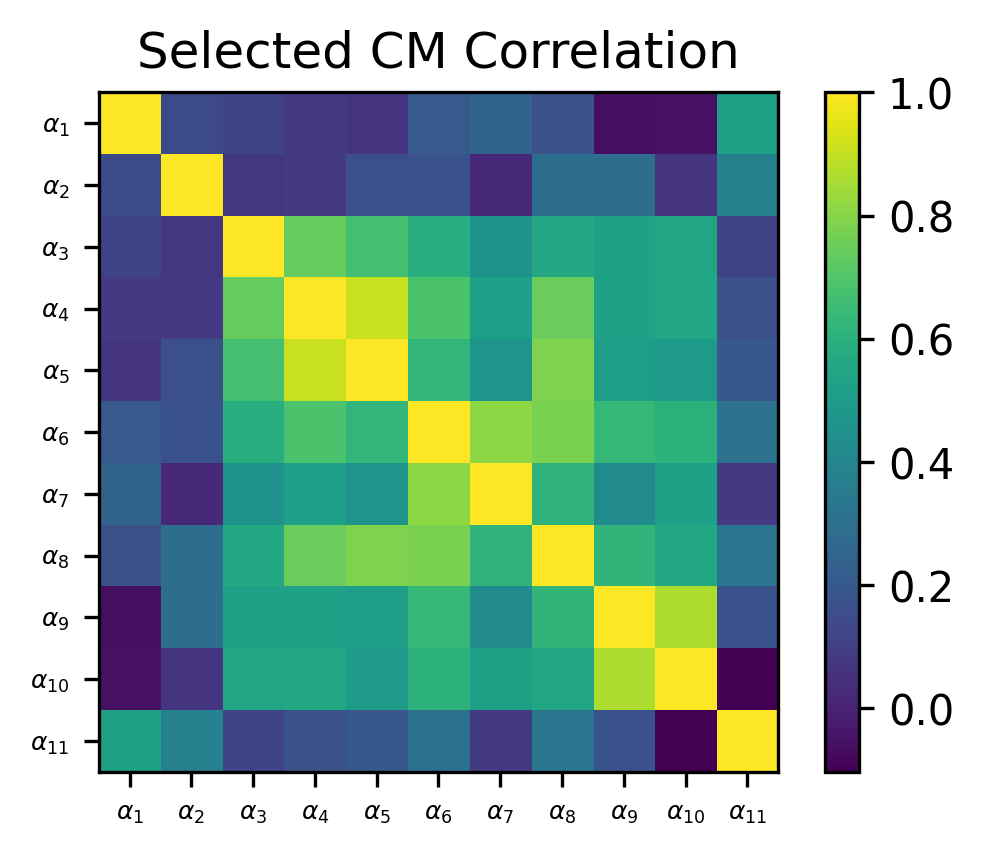

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-15",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}
Selected 35 Regions: f['AD', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'KR', 'LT', 'MX', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SG', 'SI', 'SK']


In [445]:
regions = ['AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK']
# Same, outside Europe
regions += ['AD', 'CN-HK', 'EG', 'IL', 'JP', 'KR', 'MX', 'SG']


features = ['Masks over 60',
 'Asymptomatic contact isolation',
 'Gatherings limited to 10',
 'Gatherings limited to 100',
 'Gatherings limited to 1000',
 'Business suspended - some',
 'Business suspended - many',
 'Schools and universities closed',
 'General curfew - permissive',
 'General curfew - strict',
 'Healthcare specialisation over 0.2']

dp = DataPreprocessor(end_date="2020-04-15")
data = dp.preprocess_data("../../data", regions, features)

In [451]:
with cm_effect.models.CMModelFlexibleV3(data) as model:
    model.build_cm_reduction_exp_gamma_prior()
    model.build_region_growth_prior()
    model.build_region_reliability_prior(pm.Normal, {"mu": 1, "sigma": 0.05})
    model.build_rates()
    model.build_output_model()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


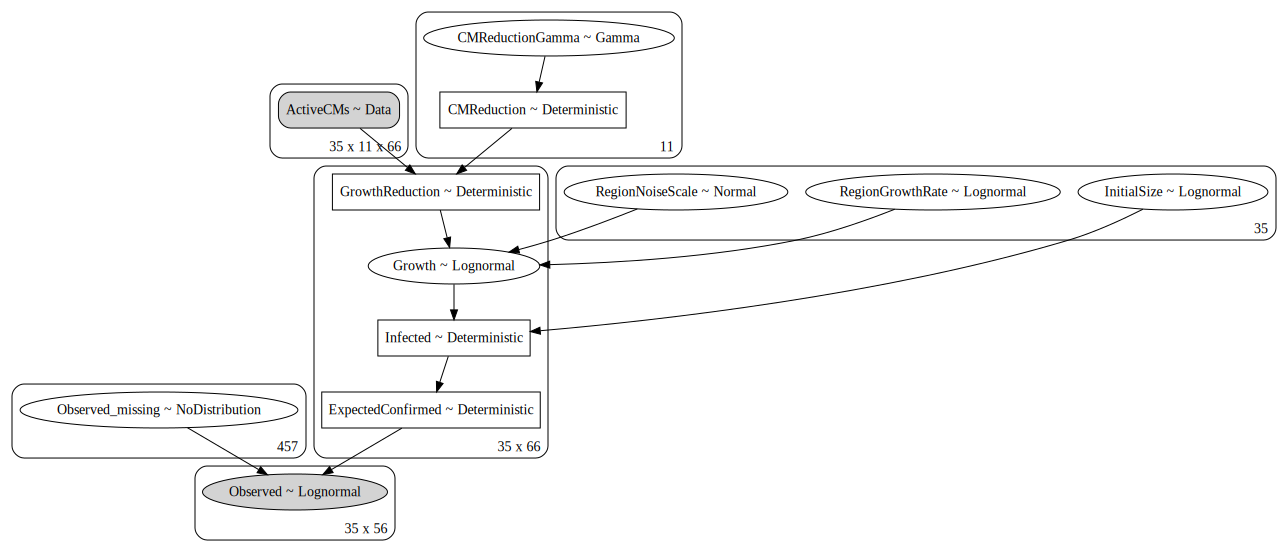

In [452]:
pm.model_to_graphviz(model).render("modelV3.1")
pm.model_to_graphviz(model)

In [453]:
model.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReductionGamma_log__         -15.61
RegionGrowthRate_log__          -0.09
RegionNoiseScale                72.69
Growth_log__                  3860.77
InitialSize_log__             -112.75
Observed_missing                 0.00
Observed                 -15231768.87
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReductionGamma]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReductionGamma]
Sampling 2 chains, 1,992 divergences: 100%|██████████| 5000/5000 [1:18:02<00:00,  1.07draws/s]
There were 1992 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1992 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.15472090808466527, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some para

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


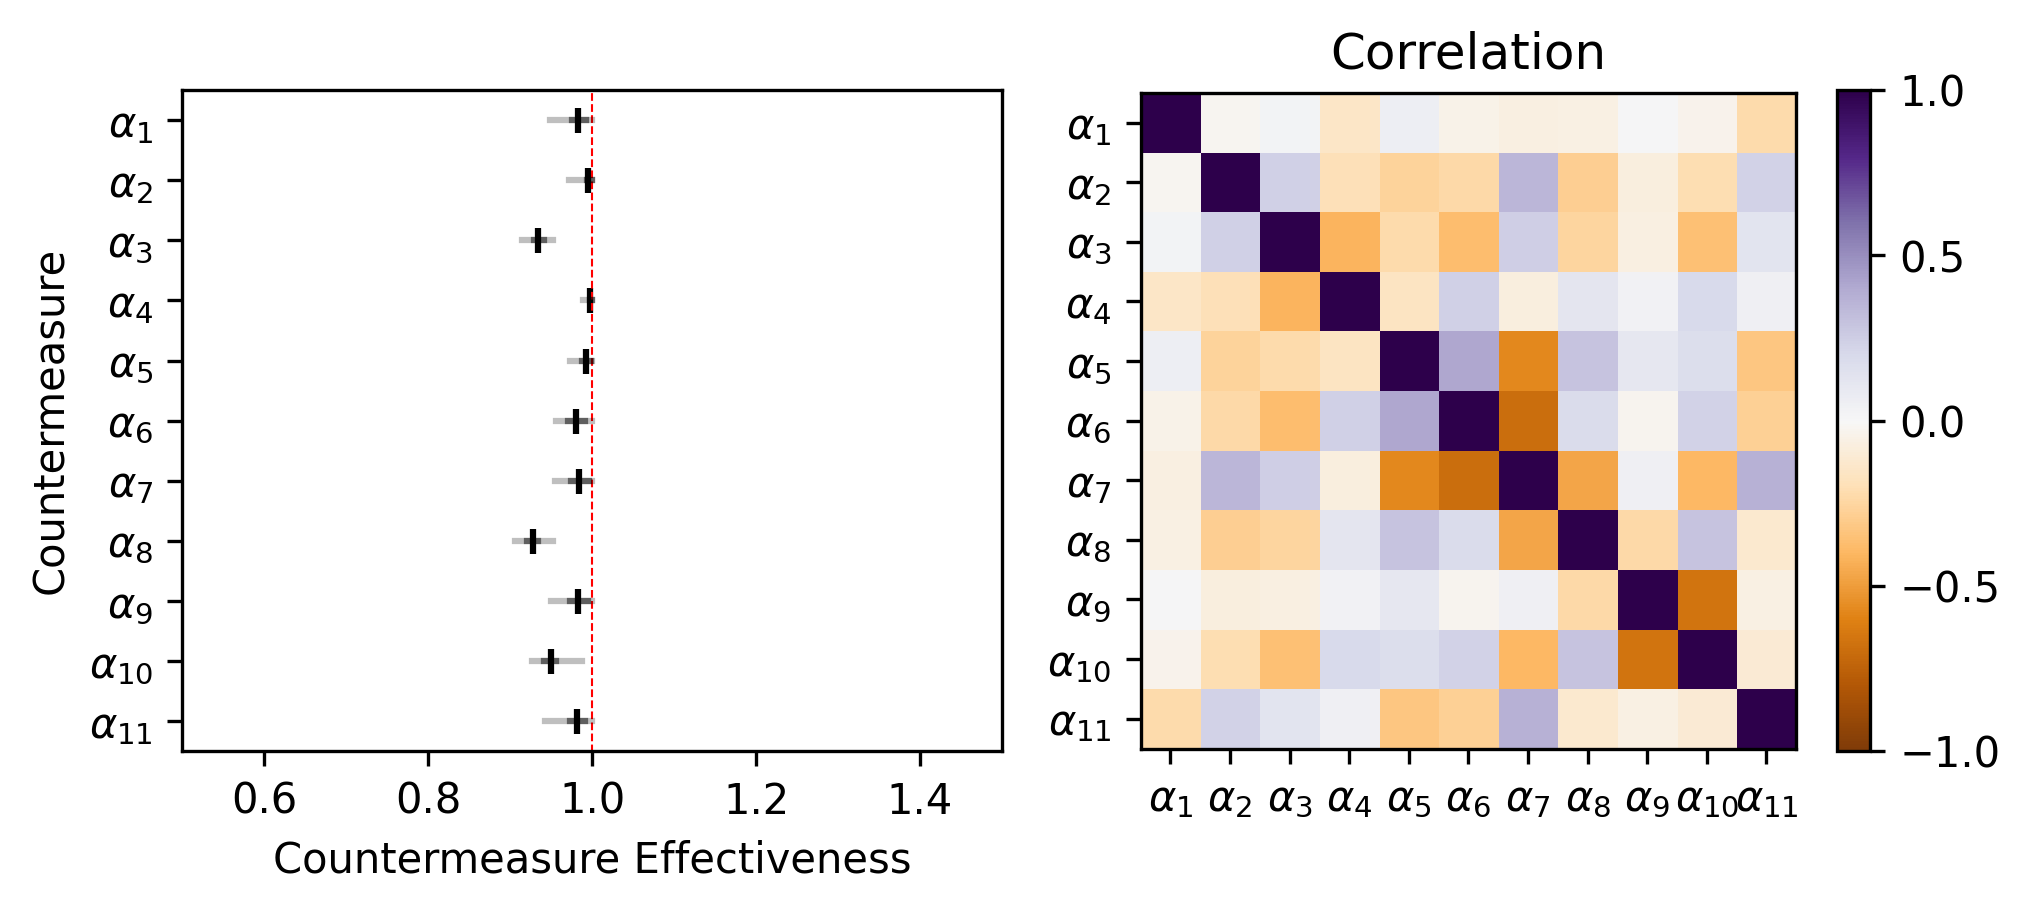

In [454]:
model.plot_effect()